In [1]:
import random

import bt
import pandas as pd

%matplotlib inline

In [ ]:
'''
단타 종목 손절 -6% / 트레일링 +12% / 스탑 -4%
중타 종목 손절 -10% / 트레일링 +20% / 스탑 - 5%
장타 종목 손절 -15% / 트레일링 +25% / 스탑 - 6%
'''

def kelly_betsize(p, b):
    """
    Calculate the Kelly Criterion for a given probability of winning and odds.
    
    Parameters:
    p (float): Probability of winning (between 0 and 1).
    b (float): Odds received on the bet (e.g., 2.0 for even money).
    
    Returns:
    float: Fraction of bankroll to bet according to the Kelly Criterion.
    """
    return (p * b - (1 - p)) / b


def kelly_rr_ratio(p, f):
    """
    Calculate the Kelly Criterion for a given probability of winning and fraction of bankroll to bet.
    
    Parameters:
    p (float): Probability of winning (between 0 and 1).
    f (float): Fraction of bankroll to bet (between 0 and 1).
    
    Returns:
    float: Kelly Criterion ratio.
    """
    return (p - 1) / (f - p)

In [43]:
kelly_betsize(0.5, 1.333333333333333333333333333333)

0.12499999999999997

In [36]:
kelly_rr_ratio(0.4, 0.1)

1.9999999999999996

In [309]:
class WeighSMADisparity(bt.Algo):
    def __init__(self, sma_period=60, **weights):
        super(WeighSMADisparity, self).__init__()
        self.sma_period = sma_period
        self.weights = weights

    def __call__(self, target):
        selected = target.temp.get('selected', [])
        if not selected: # 선택된 자산 없으면 종료
            target.temp['weights'] = {}
            return True
        
        prices = target.universe.loc[:target.now, selected]
        if len(prices) < self.sma_period:  # 데이터 부족 시 기존 weights 유지
            target.temp["weights"] = self.weights.copy()
            return True
        
        weights = pd.Series(self.weights)
        print(weights)

        smas = prices.rolling(window=self.sma_period, min_periods=self.sma_period).mean().iloc[-1]
        current_prices = prices.iloc[-1]
        disparities = (current_prices / smas).fillna(0).clip(lower=0)

        scaled_weights = 1 / disparities
        scaled_weights = scaled_weights / scaled_weights.sum()
        
        target.temp["weights"] = scaled_weights.fillna(0).to_dict()
        return True
    

class Debug(bt.Algo):
    def __call__(self, target):
        print(f"----- {target.now} -----")
        print(f"Capital: {target.capital}")
        print(f"value: {target.value}, notional_value: {target.notional_value}")
        return True

In [310]:
data = bt.get('qld, bil', start='2017-01-01', end='2025-04-30')

In [319]:
s1 = bt.Strategy('s1', [
    bt.algos.RunQuarterly(),
    bt.algos.CapitalFlow(5000),
    bt.algos.SelectAll(),
    bt.algos.WeighSpecified(qld=0.8, bil=0.2),
    bt.algos.Rebalance()
])

s2 = bt.Strategy('s2', [
    bt.algos.RunQuarterly(),        # 분기 첫 거래일에 아래 알고리즘들 실행
    bt.algos.CapitalFlow(5000),
    bt.algos.SelectAll(),           # 모든 티커 선택
    WeighSMADisparity(sma_period=60, qld=0.8, bil=0.2),
    bt.algos.Rebalance(),            # 목표 가중치에 맞춰 포트폴리오 리밸런싱
    # Debug()
])

100%|██████████| 2/2 [00:00<00:00,  6.45it/s]


qld    0.8
bil    0.2
dtype: float64
qld    0.8
bil    0.2
dtype: float64
qld    0.8
bil    0.2
dtype: float64
qld    0.8
bil    0.2
dtype: float64
qld    0.8
bil    0.2
dtype: float64
qld    0.8
bil    0.2
dtype: float64
qld    0.8
bil    0.2
dtype: float64
qld    0.8
bil    0.2
dtype: float64
qld    0.8
bil    0.2
dtype: float64
qld    0.8
bil    0.2
dtype: float64
qld    0.8
bil    0.2
dtype: float64
qld    0.8
bil    0.2
dtype: float64
qld    0.8
bil    0.2
dtype: float64
qld    0.8
bil    0.2
dtype: float64
qld    0.8
bil    0.2
dtype: float64
qld    0.8
bil    0.2
dtype: float64
qld    0.8
bil    0.2
dtype: float64
qld    0.8
bil    0.2
dtype: float64
qld    0.8
bil    0.2
dtype: float64
qld    0.8
bil    0.2
dtype: float64
qld    0.8
bil    0.2
dtype: float64
qld    0.8
bil    0.2
dtype: float64
qld    0.8
bil    0.2
dtype: float64
qld    0.8
bil    0.2
dtype: float64
qld    0.8
bil    0.2
dtype: float64
qld    0.8
bil    0.2
dtype: float64
qld    0.8
bil    0.2
dtype: float64
q

<Axes: title={'center': 'Equity Progression'}>

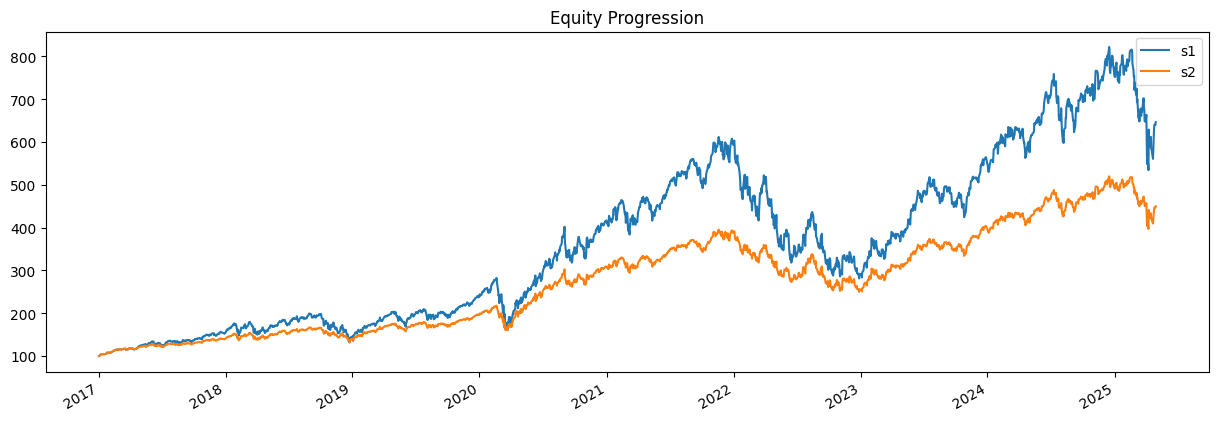

In [320]:
money = 100000
tests = [bt.Backtest(s1, data, initial_capital=money), bt.Backtest(s2, data, initial_capital=money)]
res = bt.run(*tests)
res.plot()

In [321]:
res.display()

Stat                 s1          s2
-------------------  ----------  ----------
Start                2017-01-02  2017-01-02
End                  2025-04-29  2025-04-29
Risk-free rate       0.00%       0.00%

Total Return         546.59%     349.84%
Daily Sharpe         0.80        0.91
Daily Sortino        1.25        1.44
CAGR                 25.15%      19.81%
Max Drawdown         -53.97%     -36.81%
Calmar Ratio         0.47        0.54

MTD                  -0.24%      -0.15%
3m                   -16.36%     -10.10%
6m                   -12.06%     -6.83%
YTD                  -14.31%     -8.62%
1Y                   7.61%       6.69%
3Y (ann.)            17.54%      13.56%
5Y (ann.)            22.32%      16.52%
10Y (ann.)           -           -
Since Incep. (ann.)  25.15%      19.81%

Daily Sharpe         0.80        0.91
Daily Sortino        1.25        1.44
Daily Mean (ann.)    29.33%      20.75%
Daily Vol (ann.)     36.89%      22.91%
Daily Skew           -0.27       -0.21
Dail

In [31]:
data = bt.get('qqq, qld, schd, bil, tlt, iau', start='2017-01-01', end='2023-12-31')
s1 = bt.Strategy('s1', [
    bt.algos.RunQuarterly(),
    bt.algos.CapitalFlow(3000),
    bt.algos.SelectAll(),
    bt.algos.WeighSpecified(qld=0.5, schd=0.3, bil=0.2),
    bt.algos.Rebalance()
])
money = 100000
tests = [bt.Backtest(s1, data, initial_capital=money)]
res = bt.run(*tests)


100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


<Axes: title={'center': 'Equity Progression'}>

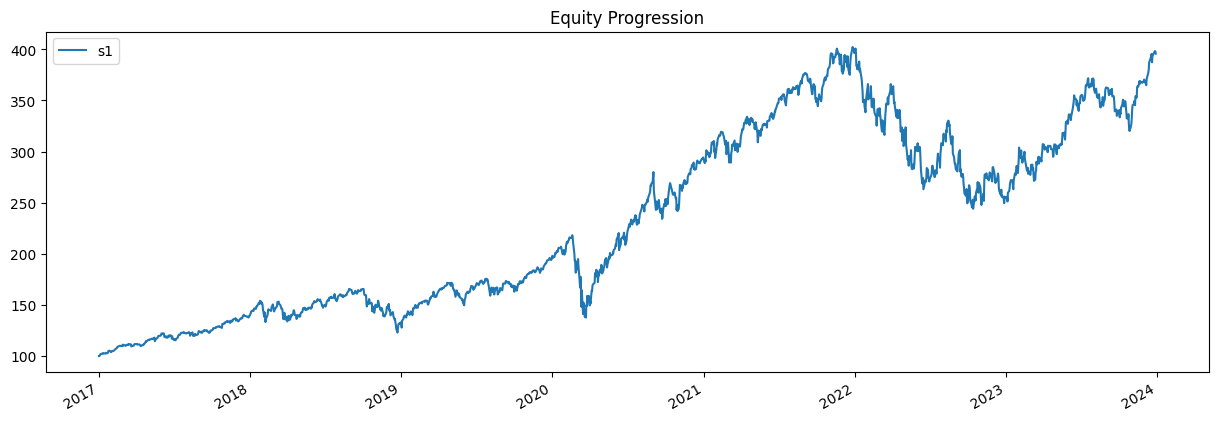

In [32]:
res.plot()

In [33]:
res.display()

Stat                 s1
-------------------  ----------
Start                2017-01-02
End                  2023-12-29
Risk-free rate       0.00%

Total Return         295.87%
Daily Sharpe         0.86
Daily Sortino        1.34
CAGR                 21.77%
Max Drawdown         -39.33%
Calmar Ratio         0.55

MTD                  7.54%
3m                   16.83%
6m                   14.01%
YTD                  54.87%
1Y                   54.64%
3Y (ann.)            10.58%
5Y (ann.)            24.47%
10Y (ann.)           -
Since Incep. (ann.)  21.77%

Daily Sharpe         0.86
Daily Sortino        1.34
Daily Mean (ann.)    23.44%
Daily Vol (ann.)     27.23%
Daily Skew           -0.52
Daily Kurt           7.23
Best Day             10.86%
Worst Day            -14.17%

Monthly Sharpe       0.91
Monthly Sortino      1.67
Monthly Mean (ann.)  22.51%
Monthly Vol (ann.)   24.67%
Monthly Skew         -0.32
Monthly Kurt         -0.06
Best Month           20.29%
Worst Month          -14.25%

Y

100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


<Axes: title={'center': 'Equity Progression'}>

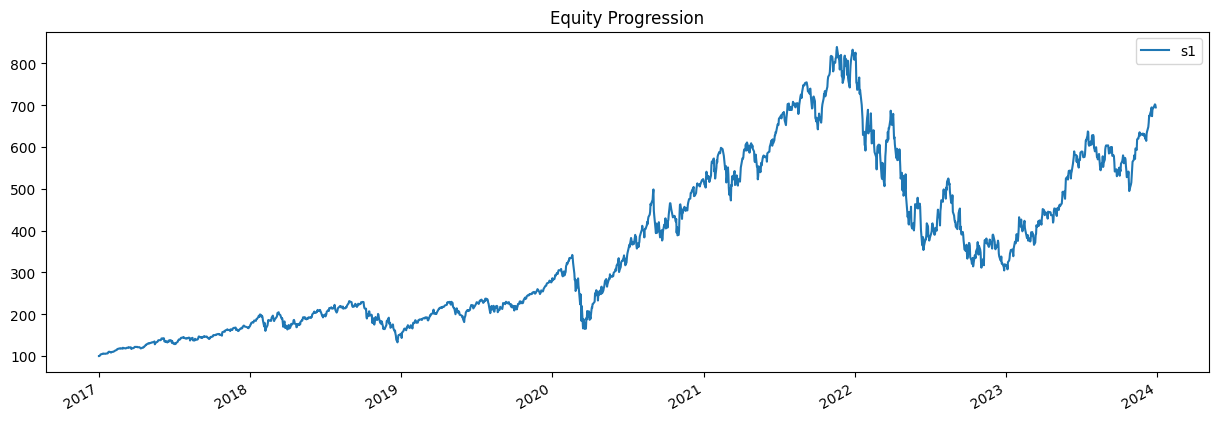

In [36]:
data = bt.get('qqq, qld, schd, bil, tlt, iau', start='2017-01-01', end='2023-12-31')
s1 = bt.Strategy('s1', [
    bt.algos.RunMonthly(),
    bt.algos.CapitalFlow(1000),
    bt.algos.SelectAll(),
    bt.algos.WeighSpecified(qld=1),
    bt.algos.Rebalance()
])
money = 5000
tests = [bt.Backtest(s1, data, initial_capital=money)]
res = bt.run(*tests)
res.plot()

In [37]:
res.display()

Stat                 s1
-------------------  ----------
Start                2017-01-02
End                  2023-12-29
Risk-free rate       0.00%

Total Return         594.89%
Daily Sharpe         0.83
Daily Sortino        1.30
CAGR                 31.98%
Max Drawdown         -63.68%
Calmar Ratio         0.50

MTD                  10.72%
3m                   28.14%
6m                   22.11%
YTD                  117.60%
1Y                   117.42%
3Y (ann.)            10.05%
5Y (ann.)            35.47%
10Y (ann.)           -
Since Incep. (ann.)  31.98%

Daily Sharpe         0.83
Daily Sortino        1.30
Daily Mean (ann.)    38.90%
Daily Vol (ann.)     46.95%
Daily Skew           -0.39
Daily Kurt           6.60
Best Day             19.05%
Worst Day            -24.27%

Monthly Sharpe       0.86
Monthly Sortino      1.60
Monthly Mean (ann.)  35.62%
Monthly Vol (ann.)   41.22%
Monthly Skew         -0.29
Monthly Kurt         -0.19
Best Month           30.80%
Worst Month          -26.02%